In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import random as rd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 

from itertools import product

import statsmodels.api as sm

import xgboost

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

from dateutil.relativedelta import *

In [2]:
common_path = '../src/preprocessed'

In [3]:
sales = pd.read_csv(f'{common_path}/sales_train.csv')
item_cat = pd.read_csv(f'{common_path}/item_categories.csv')
items = pd.read_csv(f'{common_path}/items.csv')
shops = pd.read_csv(f'{common_path}/shops.csv')
test = pd.read_csv(f'{common_path}/test.csv')

In [4]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()

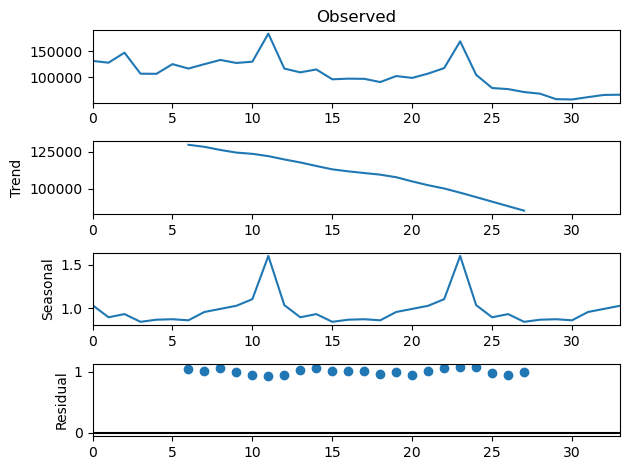

In [5]:
res = sm.tsa.seasonal_decompose(ts.values, period=12, model="multiplicative")
fig = res.plot()

Our data is seasonal with decreasing trend

First let's try to create model without any feature modeling

In [6]:
sales.head(1)

,Unnamed: 0,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,0,2013-02-01,0,59,22154,999.0,1.0,2013-02


In [7]:
class RollingWindowCV(object):
    
    def __init__(self, train_period=6, test_period=1, gap=1):
        self.train_period = train_period
        self.test_period = test_period
        self.gap = gap

        
    def split(self, data, date_column='date_block_num'):

        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []
        
        start_train = int(data[date_column].min())
        end_train = start_train + self.train_period
        start_test = end_train + self.gap
        end_test = start_test + self.test_period

        while end_test < data[date_column].max():
            cur_train_indices = list(data[(data[date_column] >= start_train) & 
                                     (data[date_column] < end_train)].index)


            cur_test_indices = list(data[(data[date_column] >= start_test) &
                                    (data[date_column] < end_test)].index)
            
            print("Train period:", start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
                  "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)


            start_train = end_train + 1
            end_train = start_train + self.train_period
            start_test = end_train + self.gap
            end_test = start_test + self.test_period
        
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        return self.n_splits 

In [8]:
train = []
cols  = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales_train = sales[sales['date_block_num'] == i]
    train.append(
        np.array(
            list(product(
                [i],
                sales_train['shop_id'].unique(),
                sales_train['item_id'].unique()
            )),
            dtype = np.int16
        )
    )

train = pd.DataFrame(np.vstack(train), columns=cols)
train = train.astype({
    'date_block_num': np.int8, 
    'shop_id': np.int8, 
    'item_id': np.int16
})
train.sort_values(cols, inplace=True)

In [9]:
sales['total_sales'] = sales['item_cnt_day'] * sales['item_price']

In [10]:
item_cnt_month = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'item_cnt_day': 'sum'})

item_cnt_month.columns = ['item_cnt_month']
item_cnt_month.reset_index(inplace=True)

train = pd.merge(train, item_cnt_month, on=cols, how='left')
train['item_cnt_month'] = train['item_cnt_month'].fillna(0).astype(np.float16)

In [11]:
train

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
10782127,33,59,22162,0.0
10782128,33,59,22163,0.0
10782129,33,59,22164,0.0
10782130,33,59,22166,0.0


In [12]:
test = test[['shop_id', 'item_id']]

In [13]:
test['date_block_num'] = 34

In [14]:
train = pd.concat([train, test],ignore_index=True, sort=False, keys=cols)
train.fillna(0, inplace=True)

In [15]:
train = pd.merge(train, items.drop('Unnamed: 0', axis=1), on='item_id', how='left')
train = pd.merge(train, item_cat.drop('Unnamed: 0', axis=1), on='item_category_id', how='left')
train = pd.merge(train, shops.drop('Unnamed: 0', axis=1), on='shop_id', how='left')

In [16]:
def add_lags(df, periods, cols):
    for col in cols:
        temp = df[['date_block_num', 'shop_id', 'item_id', col]]
        for per in periods:
            shifted = temp.copy()
            shifted.columns = ['date_block_num', 'shop_id', 'item_id', col + "_lag_" + str(per)]
            shifted['date_block_num'] = shifted['date_block_num'] + per
            df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

Usefull lags: 
    - item_cnt_month for periods

In [17]:
train = add_lags(train, [1, 12], ['item_cnt_month'])

In [ ]:
tscv = RollingWindowCV()
linregs = []
for train_index, test_index in tscv.split(train, date_column='date_block_num'):
    train_sub = train.loc[train_index]
    valid_sub = train.loc[test_index]
    
    X_train = train_sub.drop(['item_cnt_month'], axis=1)
    y_train = train_sub['item_cnt_month']
    
    X_valid = test_sub.drop(['item_cnt_month'], axis=1)
    y_valid = test_sub['item_cnt_month']
    
    X_train = X_train.fillna(0)
    y_train = y_train.fillna(0)
    
    X_valid = X_valid.fillna(0)
    y_valid = y_valid.fillna(0)
    
    y_train = y_train.clip(0, 30)
    y_valid = y_valid.clip(0, 30)
    
    model = SGDRegressor(max_iter=10_000)
    model.fit(X_train, y_train)
    
    model = XGBRegressor(
       max_depth=8,
       n_estimators=800,
       min_child_weight=0.8, 
       colsample_bytree=0.8, 
       subsample=0.8, 
       eta=0.1,
       used_ram_limit= "12gb",
    )

    model.fit(
       X_train, 
       y_train, 
       eval_metric='rmse',
       eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
       verbose=True, 
       early_stopping_rounds=10
    )
    
    print(mean_squared_error(y_valid, model.predict(X_valid), squared=False))
    linregs.append(model)
    
    

Train period: 0 - 6 , Test period 7 - 8 # train records 2260882 , # test records 361170
Train period: 7 - 13 , Test period 14 - 15 # train records 2186175 , # test records 334311
Train period: 14 - 20 , Test period 21 - 22 # train records 1936366 , # test records 321963
Train period: 21 - 27 , Test period 28 - 29 # train records 1804844 , # test records 228888
6185474867617424.0


In [251]:
X_train.fillna()

,date_block_num,shop_id,item_id,item_category_id,name2,name3,type_code,subcat,shop_category,shop_city,item_cnt_month_lag_1,item_cnt_month_lag_12
0,0,2,19,40,4,42,5,4,9,0,NaN,NaN
1,0,2,27,19,77,42,3,10,9,0,NaN,NaN
2,0,2,28,30,108,42,3,55,9,0,NaN,NaN
3,0,2,29,23,124,42,3,16,9,0,NaN,NaN
4,0,2,32,40,4,42,5,4,9,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2260877,5,59,22151,40,4,247,5,4,9,30,0.0,NaN
2260878,5,59,22152,40,4,251,5,4,9,30,0.0,NaN
2260879,5,59,22155,37,4,562,5,1,9,30,0.0,NaN
2260880,5,59,22157,40,4,42,5,4,9,30,0.0,NaN
